In [1]:
from matplotlib import pyplot as plt 
import numpy as np 
import pickle as pkl
import os
from scipy.stats import spearmanr
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
import statsmodels.api as sm

import sys 
sys.path.append('../src/')
from utils import load_config, get_corruption_scores

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Impact of iteration on characterization of noise 

- is early or late stage training better at characterizing noise ? 
- how do we optimize the iteration hyperparameter ? 


In [169]:
_dir = '../results/exp8/' 
uid = '0beb2b54-39b4-44de-9de6-9e55b1126809'#'39fe0888-acf7-4fd3-b31f-d1dd5b65c3e2' #aaba8613-abe3-402f-b52c-c6902213bca4' #'a38cf5c5-d4f5-462e-98d9-f5d345332f58'

# exp7 
#'fb448b51-2351-418d-b727-3ec792c2fd49'# 'ef598eb1-1237-409e-84bc-38e213777482'
# 'f3832f2e-a9e1-47f7-81d9-190f688594f3'
# 'fb448b51-2351-418d-b727-3ec792c2fd49'

In [170]:
res = pd.read_csv(_dir + 'results.csv', sep='\t')
res.tail() 

,uid,config,config-checksum,method,perf_filter_low,perf_filter_high,runtime_s
3,39fe0888-acf7-4fd3-b31f-d1dd5b65c3e2,../configs/exp8.py,ceb87b5de6174bcca4ed495ddcc38615,dvgs,"[0.7011882434573434, 0.7013306539080534, 0.699...","[0.699606006837727, 0.6897393600178805, 0.6753...",2874.555716
4,46f31ccd-e2e4-4c27-a7c4-66a941673522,../configs/exp8.py,959d7d015e5d1a77b7a6ebc021c62b57,dvgs,"[0.6002427027790525, 0.5972834879373019, 0.592...","[0.6001271979624166, 0.5686242523226109, 0.518...",1340.797757
5,418c479b-b409-48d4-825b-b52f3da315e0,../configs/exp8.py,6fe5e854f61b145b035b850b42ceba34,dvgs,"[0.602521019952174, 0.5999231307059991, 0.5951...","[0.601954147980023, 0.5704253300459006, 0.5224...",2338.181686
6,c7f59c98-dced-43e6-9beb-5fe304f87a82,../configs/exp8.py,a96312d01c753ef962877db727028694,dvgs,"[0.6249281873279736, 0.6239637017316584, 0.620...","[0.623380356717889, 0.6011401883214971, 0.5608...",1269.450234
7,0beb2b54-39b4-44de-9de6-9e55b1126809,../configs/exp8.py,c9d6c23b5769fb6f03c28215112d0256,dvgs,"[0.6225438819627596, 0.6215213934281768, 0.618...","[0.6230922602135196, 0.5979317672255261, 0.562...",2421.421038


In [171]:
exog_noise = np.load(_dir + '/data_values/' + uid + '/exog_noise.npy')
exog_noise

array([2.2280176 , 1.4322927 , 2.459231  , ..., 1.4153411 , 0.98134536,
       0.22916096], dtype=float32)

In [172]:
data_values = np.load(_dir + '/data_values/' + uid + '/data_values.npy')
data_values

array([0.04622962, 0.10703745, 0.06966357, ..., 0.05648307, 0.05366441,
       0.08743241], dtype=float32)

In [173]:
# overall correlation between data values and noise 
p_all = spearmanr(data_values, exog_noise)[0]
p_all

-0.501039956532412

In [174]:
fs = os.listdir(_dir + '/dvgs/' + uid + '/')
vals = [None]*len(fs)

for f in fs: 
    ii = int(f.split('=')[-1].split('.')[0]) - 1
    vals[ii] = np.load(_dir + '/dvgs/' + uid + '/' + f)

In [175]:
ps = np.array([spearmanr(v, exog_noise)[0] for v in vals])

lowess = sm.nonparametric.lowess
lowess_fit = lowess(exog=np.arange(len(ps)), endog=ps, return_sorted=False, frac=0.4)

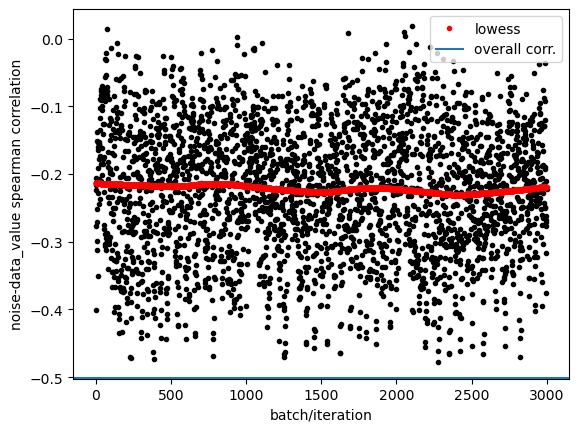

In [176]:
plt.figure()
plt.plot(np.arange(len(ps)), ps, 'k.')
plt.plot(np.arange(len(ps)), lowess_fit, 'r.', label='lowess')
plt.axhline(p_all, label='overall corr.')
plt.xlabel('batch/iteration')
plt.ylabel('noise-data_value spearman correlation')
plt.legend()
plt.show()

In [177]:
cum_ps = [spearmanr(np.mean(np.stack(vals[:i], axis=0), axis=0), exog_noise)[0] for i in range(2, len(vals))]

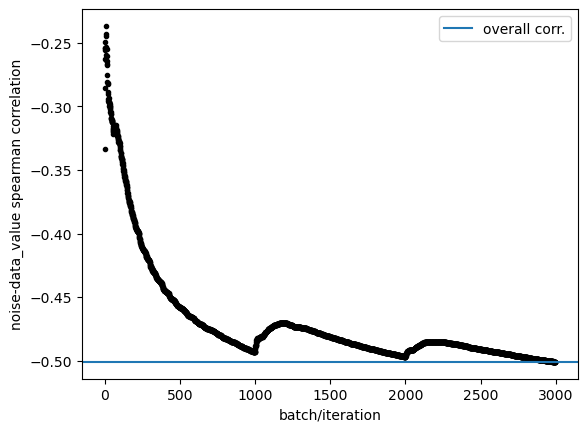

In [178]:
plt.figure()
plt.plot(cum_ps, 'k.')
plt.axhline(p_all, label='overall corr.')
plt.xlabel('batch/iteration')
plt.ylabel('noise-data_value spearman correlation')
plt.legend()
plt.show()